In [1]:
# -*- coding: utf-8 -*-:
import time

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
from pcs import tx
from pcs import helper as hlp
from pcs import utils
from pcs import autoencoder as ae

# Parameters

In [3]:
# Channel Parameters
chParam = utils.AttrDict()
chParam.M = 16
chParam.SNR_db = 5

# Auto-Encoder Parameters
aeParam = utils.AttrDict()
aeParam.nLayersEnc  = 1
aeParam.nLayersDec  = 5
aeParam.nFeaturesEnc  = 128
aeParam.nFeaturesDec  = 128

# Training Parameters
trainingParam = utils.AttrDict()
trainingParam.nBatches      = 16
trainingParam.batchSize     = 64*chParam.M
trainingParam.learningRate  = 0.01
trainingParam.iterations    = 31
trainingParam.displayStep   = 5

# Experiments

In [4]:
def p_norm(p, x, fun=lambda x: torch.pow(torch.abs(x), 2)):
    return torch.sum(p * fun(x))

In [5]:
indices = np.random.choice(chParam.M,1)
onehot = F.one_hot(torch.tensor(indices, dtype=torch.int64), chParam.M)
P_M = torch.tensor(np.ones(chParam.M)*1/chParam.M)
norm_constellation = np.array([[-1.6953, -1.4693, -1.2432, -1.0172, -0.7912, -0.5651, -0.3391, -0.1130,
         0.1130,  0.3391,  0.5651,  0.7912,  1.0172,  1.2432,  1.4693,  1.6953]]).transpose()
x = np.matmul(onehot, torch.tensor(norm_constellation))

In [6]:
noise = torch.randn(1).reshape(-1, 1)
sigma2 = torch.tensor(1) / hlp.dB2lin(chParam.SNR_db, 'dB')  # 1 corresponds to the Power
noise = torch.sqrt(sigma2) * noise
y = torch.add(x, noise)

In [7]:
N0 = torch.mean(torch.square(torch.abs(x - y)))

qY = []

qYonX = (1 / torch.sqrt(torch.tensor(2) * torch.pi * N0)) * torch.exp( -torch.square(y - x) / (torch.tensor(2) * N0))

for ii in np.arange(chParam.M):
    temp = P_M[ii] * (1 / torch.sqrt(torch.tensor(2) * torch.pi * N0)) * torch.exp(-torch.square( y - norm_constellation[ii]) / (torch.tensor(2) * N0 ))
    qY.append(temp)

qY = torch.sum(torch.cat(qY, dim=0), dim=0)

qXonY = P_M[indices] * qYonX / qY

HX = -p_norm(P_M, P_M, lambda x: torch.log2(x))

MI = HX - torch.mean(-torch.log2(qXonY))


# Implementation

In [5]:
def sampler(P_M, B):
    samples = torch.empty(0)
    for idx, p in enumerate(P_M):
        occurrences = torch.round(B * p).type(torch.LongTensor)
        samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]

In [6]:
def calculate_py_given_x(z, sig2):
     return (1 / (torch.sqrt(2 * torch.pi * sig2))) * torch.exp(-torch.square(z) / (sig2 * torch.tensor(2)))

In [7]:
def calculate_px_given_y(x, y, sigma2, chi):
    py = 0
    for i in chi:
        py += 0.25 * calculate_py_given_x(i, y, sigma2)
    pxy = 0.25 * calculate_py_given_x(x, y, sigma2) / py
    return pxy

In [8]:
def generate_AWGN(x_shape, SNR_db):
    noise = torch.randn(x_shape)
    sigma2 = torch.tensor(1) / hlp.dB2lin(SNR_db, 'dB')  # 1 corresponds to the Power
    noise = torch.sqrt(sigma2) * noise
    noise_power = torch.mean(torch.square(torch.abs(noise)))
    return noise, sigma2, noise_power

In [9]:
def plot_PDF( ask, pmf, db):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(ask, pmf)
    ax.set_title(f'SNR = {db} dB')
    ax.grid()
    fig.show()

In [10]:
enc_inp = torch.tensor([[1]], dtype=torch.float)
# AWGN Capacity
AWGN_Cap = 0.5 * np.log2(1 + hlp.dB2lin(chParam.SNR_db, 'dB'))

In [11]:
# Initialize network
encoder = ae.Encoder_Aref(in_features=1, width=aeParam.nFeaturesEnc, out_features=chParam.M)
decoder = ae.Decoder_Aref(in_features=1, width=aeParam.nFeaturesDec, out_features=chParam.M)
CEloss = nn.CrossEntropyLoss()

In [12]:
# Optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=trainingParam.learningRate)

C:\Users\David\AppData\Local\Temp/ipykernel_21008/4269678781.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


tensor(1., grad_fn=<SumBackward0>)


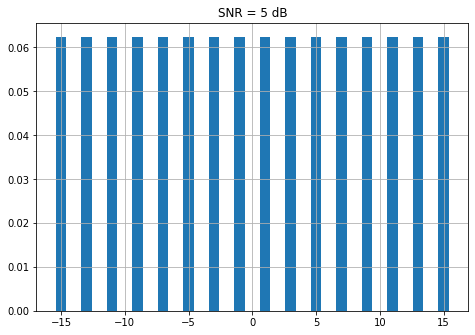

In [13]:
p_s_t = F.softmax(encoder(enc_inp), dim=1)
p_s = p_s_t.detach().numpy()[0]
constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
plot_PDF(constellation, p_s, chParam.SNR_db)
print(torch.sum(p_s_t))

In [19]:
def loss_correction_factor(dec, zhat, sig2):
     q = torch.amax(dec, 1)  # Q(c_i|Y_n) <-- learned
     p = calculate_py_given_x(zhat, sig2) # P(Y_n|c_i)
     return torch.sum(p * torch.log2(q))


# Training loop
for j in range(trainingParam.iterations):
    for i in range(trainingParam.nBatches):
        # first generate the distribution
        l_M = encoder(enc_inp)
        P_M = F.softmax(l_M, dim=1)
        dP_M = torch.mean(-torch.log2(P_M*torch.e))

        # Sample indexes
        indices = sampler(torch.squeeze(P_M), trainingParam.batchSize).type(torch.LongTensor)  # labels
        # get onehot from sampled indices
        onehot = F.one_hot(indices, chParam.M)


        # normalization & Modulation
        constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
        constellation_t = torch.tensor(constellation, dtype=torch.float)
        norm_factor = torch.rsqrt(utils.p_norm(P_M, constellation_t))
        norm_constellation = torch.mul(constellation_t, norm_factor)
        x = torch.matmul(onehot.type(torch.FloatTensor), norm_constellation)
        should_always_be_one = utils.p_norm(P_M, norm_constellation)

        # Channel
        noise_snr, sigma2, noise_power = generate_AWGN(x.shape, chParam.SNR_db)
        y = torch.add(x, noise_snr)
        y_power = utils.p_norm(P_M, torch.add(norm_constellation, generate_AWGN(norm_constellation.shape, chParam.SNR_db)[0] ))

        # demodulator
        y_vec = torch.reshape(y, (-1, 1))
        dec = decoder(y_vec)

        # loss
        zhat = torch.sub(y, x)
        loss = CEloss(dec, onehot.type(torch.float))
        factor = loss_correction_factor(F.softmax(dec, 1), zhat, sigma2)

        optimizer.zero_grad()
        loss.backward()

        for p in encoder.parameters():
            p.grad += (dP_M + factor)

        optimizer.step()

        MI = utils.gaussianMI_ASK_Non_Uniform(indices, x, y, norm_constellation, chParam.M, P_M, dtype=torch.double).detach().numpy()

    # Printout and visualization
    if j % int(trainingParam.displayStep) == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f} - always 1: {should_always_be_one :.2} - MI: {MI :.4f} - Cap.: {AWGN_Cap:.4f}')
    if (loss.detach().numpy() / np.log(2)) < -100.0:
        break

<string>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
<string>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0: Loss = 3.0154 - always 1: 1.0 - MI: 0.9929 - Cap.: 1.0287
epoch 5: Loss = 3.0381 - always 1: 1.0 - MI: 0.9685 - Cap.: 1.0287
epoch 10: Loss = 3.0431 - always 1: 1.0 - MI: 0.9630 - Cap.: 1.0287
epoch 15: Loss = 3.0425 - always 1: 1.0 - MI: 0.9687 - Cap.: 1.0287
epoch 20: Loss = 2.9850 - always 1: 1.0 - MI: 1.0261 - Cap.: 1.0287
epoch 25: Loss = 2.9439 - always 1: 1.0 - MI: 1.0693 - Cap.: 1.0287
epoch 30: Loss = 2.9483 - always 1: 1.0 - MI: 1.0406 - Cap.: 1.0287


Power should always be one: tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)


C:\Users\David\AppData\Local\Temp/ipykernel_21008/4269678781.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


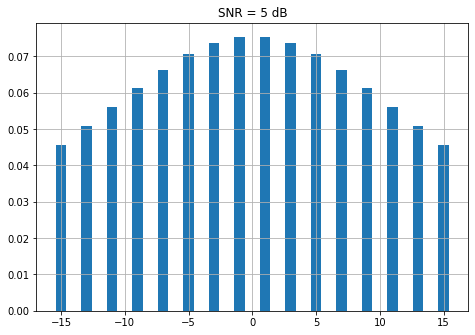

In [20]:
# Data for the plots
p_s_t = F.softmax(encoder(enc_inp), dim=1)
p_s = p_s_t.detach().numpy()[0]
constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
constellation_t = torch.tensor(constellation, dtype=torch.float64)
norm_factor = torch.rsqrt(utils.p_norm(p_s_t, constellation_t))
norm_constellation = norm_factor * constellation_t
print('Power should always be one:', utils.p_norm(p_s_t, norm_constellation))
plot_PDF(constellation, p_s, chParam.SNR_db)